Online Gaming Anxiety Data 



GAD (Generalized Anxiety Disorder)

GAD1 - GAD7: Individual question scores on the GAD-7 questionnaire

GAD_T: Total GAD score (0–21)

Score Range	Interpretation

0–4	Minimal anxiety

5–9	Mild anxiety

10–14	Moderate anxiety

15–21	Severe anxiety




SWL (Satisfaction With Life)

SWL1 - SWL5: Individual question scores on the SWL questionnaire

SWL_T: Total SWL score (5–35)



Score Range	Interpretation

5–9	Extremely dissatisfied

10–19	Dissatisfied

20–24	Neutral

25–29	Satisfied

30–35	Extremely satisfied



SPIN (Social Phobia Inventory)

SPIN1 - SPIN17: Individual question scores on the SPIN questionnaire

SPIN_T: Total SPIN score (0–68)



Score Range	Interpretation

0–20	No social phobia

21–30	Mild social phobia

31–40	Moderate social phobia

41–50	Severe social phobia

51+	Very severe social phobia


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sns
from dotenv import load_dotenv
import os
import numpy as np
import plotly.express as px

In [2]:
sns.set()

In [3]:
df=pd.read_csv("GamingStudy_data.csv",encoding='ISO-8859-1')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='D', origin='1899-12-30')


In [4]:
df=df[["S. No.","GAD_T","GADE","SWL_T","Game","Platform","Hours","earnings","whyplay","League","streams","SPIN_T","Narcissism","Gender","Age","Work","Degree","Playstyle","Birthplace","Residence"]].copy()
df=df.rename(columns={'S. No.': 'ID',"Hours":"Hours_weekly"})


In [5]:

bins_A = [-1, 4, 9, 14, 21]
labels_A = ["Mínima", "Leve", "Moderada", "Severa"]
df['Nivel_Ansiedad'] = pd.cut(df['GAD_T'], bins=bins_A, labels=labels_A)

bins_S=[4,9,19,24,29,35]
labels_S = [
    "Extremely dissatisfied",
    "Dissatisfied",
    "Neutral",
    "Satisfied",
    "Extremely satisfied"
]

df["Nivel_Satisfacción"]=pd.cut(df["SWL_T"],bins=bins_S,labels=labels_S)

bins_F=[-1,20,30,40,50,68]
labels_F=[" No social phobia",
          "Mild social phobia",
          "Moderate social phobia",
          "Severe social phobia",
          "Very severe social phobia"

          ]    

df["Nivel_Fobia_social"]=pd.cut(df["SPIN_T"],bins=bins_F,labels=labels_F)

df=df.dropna(subset=["Hours_weekly"])
#rellenado los nulos de streams con 0 asumiendo que el que no ha contestado es porque no los consume
df["streams"]=df["streams"].fillna(0)

df["Horas_totales"]=df["Hours_weekly"] + df["streams"]

In [6]:
df["GADE"]=df["GADE"].fillna("Sin contestar")


df["Nivel_Fobia_social"] = df["Nivel_Fobia_social"].cat.add_categories(["Sin contestar"])


df["Nivel_Fobia_social"] = df["Nivel_Fobia_social"].fillna("Sin contestar")


df["Degree"]=df["Degree"].fillna("Sin contestar")

df["Work"]=df["Work"].fillna("Sin contestar")


df=df.dropna(subset=["Hours_weekly"])
#Pongo el limite en 140h semanales conjuntas ya que me parece uan cifra muy extrema y mas que eso no creo que sea realista
df = df[~(df['Horas_totales'] > 140)].copy()




In [7]:
# Creamos la columna: 1 si vive en un país distinto, 0 si es el mismo

df['Is_Migrant'] = (df['Birthplace'] != df['Residence']).astype(int)

In [8]:
df["GADE"]=pd.Categorical(df["GADE"],categories=["Not difficult at all","Somewhat difficult","Very difficult","Extremely difficult"],ordered=True)


df["Degree"] = df["Degree"].str.replace(u'\xa0', u' ', regex=True).str.strip()


orden_estudios = [
    'High school diploma (or equivalent)',
    'Bachelor (or equivalent)',
    'Master (or equivalent)',
    'Ph.D., Psy. D., MD (or equivalent)'
]

df["Degree"] = pd.Categorical(df["Degree"], categories=orden_estudios, ordered=True)

In [9]:
top_4_reasons = df['whyplay'].value_counts().nlargest(4).index

# 2. Creamos la columna limpia

df['whyplay_Clean'] = df['whyplay'].where(df['whyplay'].isin(top_4_reasons))

In [10]:
df.info() 


<class 'pandas.core.frame.DataFrame'>
Index: 13419 entries, 0 to 13463
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   ID                  13419 non-null  int64   
 1   GAD_T               13419 non-null  int64   
 2   GADE                12773 non-null  category
 3   SWL_T               13419 non-null  int64   
 4   Game                13419 non-null  object  
 5   Platform            13419 non-null  object  
 6   Hours_weekly        13419 non-null  float64 
 7   earnings            13419 non-null  object  
 8   whyplay             13419 non-null  object  
 9   League              11571 non-null  object  
 10  streams             13419 non-null  float64 
 11  SPIN_T              12773 non-null  float64 
 12  Narcissism          13396 non-null  float64 
 13  Gender              13419 non-null  object  
 14  Age                 13419 non-null  int64   
 15  Work                13419 non-null  objec

Limieza de la fila de Rangos 

solo usare los de League of Legends ya que son un 84% de la muestra y el resto son juegos con muy pocos usuarios y los rangos no son comparables.

In [11]:
Rangos_LOL=[
"Unranked",
"Bronze",
"Silver",
"Gold",
"Platinum",
"Diamond",
"Master",
"Challenger"]

df["LOL_Rank"]=np.nan
df["LOL_Rank"]=df["LOL_Rank"].astype(object)
for Rango in Rangos_LOL :
    mask=(df["Game"]=="League of Legends") & (df["League"].str.contains(Rango,case=False,na=False))
    
    df.loc[mask,"LOL_Rank"]=Rango

In [12]:
# Filtramos: Juegan al LoL pero la columna limpia está vacía 
fuera_del_filtro = df[(df['Game'] == 'League of Legends') & (df['LOL_Rank'].isna())]['League']

# Vemos el top 30 de esas respuestas ignoradas
print(fuera_del_filtro.value_counts())

League
Plat 5                        53
Plat                          46
Plat 3                        44
plat                          39
Plat 1                        39
                              ..
platine 5                      1
Not ranked yet this season     1
Diaomnd 5                      1
platin                         1
AHGL                           1
Name: count, Length: 314, dtype: int64


In [13]:

rescate = {
    "Unranked": ["unraked","unrank", "not ranked", "placements", "not placed", "provisionals","none","noone","-","na","not rated","n/a","placement","new","no rank","un","play","30","ranked","Just started!","lvl28","level"],
    "Bronze": ["b1","b2", "b3","b4", "b5","bronce","broze"],
    "Silver": ["s1","s2", "s3", "s4", "s5","sliver","sil","siver"],
    "Gold": ["g1", "g2", "g3", "g4","g5", "golf","golld","g 2","GIII","goled","gv","glod"],
    "Platinum": ["p1", "p2","p3","p4","p5","plat", "platin", "plarinum", "platnium","plantinum"],
    "Diamond": ["d1","d2","d3","d4","d5","dia 5","dia","d 5"],
    "Challenger": ["chall","AHGL","charrenjour"],
}

for rango_oficial, abreviaturas in rescate.items():
    for palabra in abreviaturas:
        
        mask = (df['Game'] == 'League of Legends') & \
               (df['League'].str.contains(palabra, case=False, na=False)) & \
               (df['LOL_Rank'].isna()) 
        
        df.loc[mask, 'LOL_Rank'] = rango_oficial


In [14]:
df['LOL_Rank'] = pd.Categorical(df['LOL_Rank'], categories=Rangos_LOL, ordered=True)

In [15]:
df['LOL_Rank'].value_counts()

LOL_Rank
Gold          2921
Platinum      2373
Silver        2102
Diamond       1431
Unranked       533
Bronze         502
Master         103
Challenger      79
Name: count, dtype: int64

In [16]:

nulos_lol = df[df["Game"] == "League of Legends"]["League"].isna().sum()
print(f"Jugadores de LoL con rango nulo: {nulos_lol}")

Jugadores de LoL con rango nulo: 1211


Como es mi muestra?

Edad

<Axes: ylabel='Frequency'>

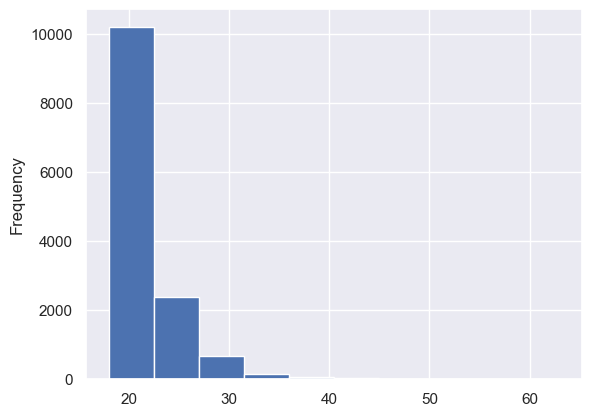

In [17]:
df["Age"].plot.hist()

<Axes: >

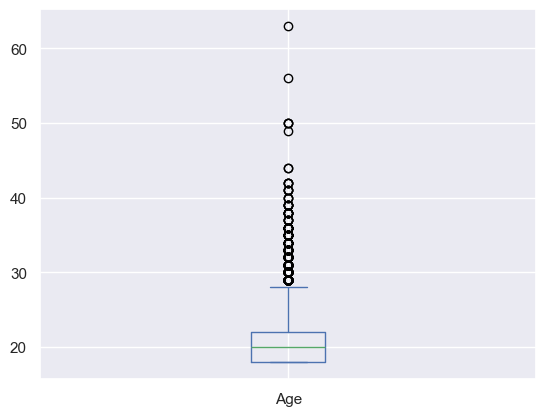

In [18]:
df["Age"].plot.box()

Género

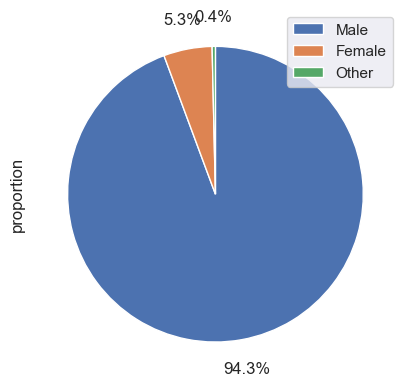

In [19]:
gender_data = df['Gender'].value_counts(normalize=True)

gender_data.plot.pie(
    startangle=90,
    autopct='%1.1f%%',
    counterclock=False,
    labels=None,      # Quitamos las etiquetas del dibujo para que no choquen
    pctdistance=1.2 # Aleja un poco los porcentajes del centro
)
plt.legend(labels=gender_data.index, loc="best")

Pais

In [21]:
dfpaises=df["Birthplace"].value_counts().reset_index()
dfpaises.columns = ['Birthplace', 'count']

total_muestras = dfpaises['count'].sum()
dfpaises['percentage'] = (dfpaises['count'] / total_muestras) * 100

top_10 = dfpaises.nlargest(10, 'count')

fig=px.treemap(top_10,
               path=["Birthplace"],
               values="count",
               custom_data=['percentage'],
               title="Distribución de paises de los usuarios(top 10)")

fig.update_traces(
    texttemplate="<b>%{label}</b><br>%{customdata[0]:.2f}%",
    hovertemplate="<b>%{label}</b><br>Cantidad: %{value}<br>Porcentaje: %{customdata[0]:.2f}%"
)

fig.show()

Estudios

In [22]:
Estudios=df["Degree"].value_counts()

<Axes: xlabel='Degree'>

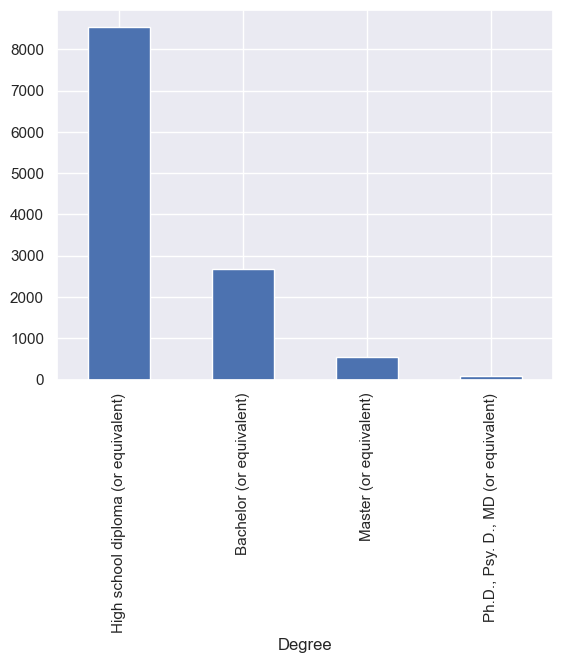

In [23]:
Estudios.plot.bar()

Estado laboral


In [25]:
Trabajo=df["Work"].value_counts()

<Axes: xlabel='Work'>

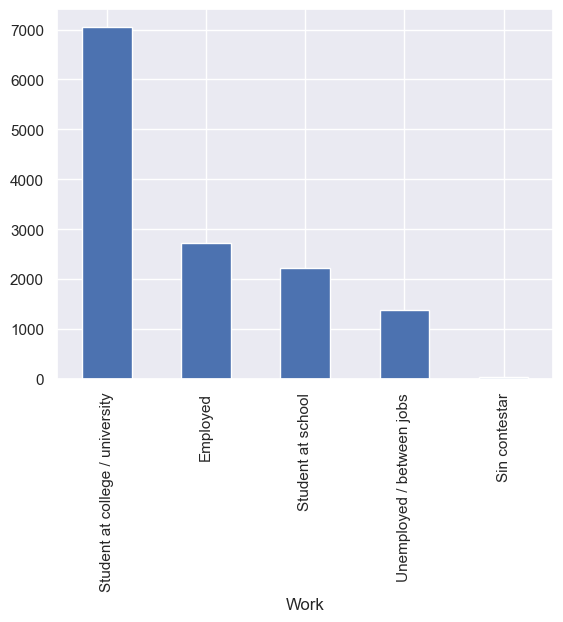

In [26]:
Trabajo.plot.bar()

estudios vs trabajo


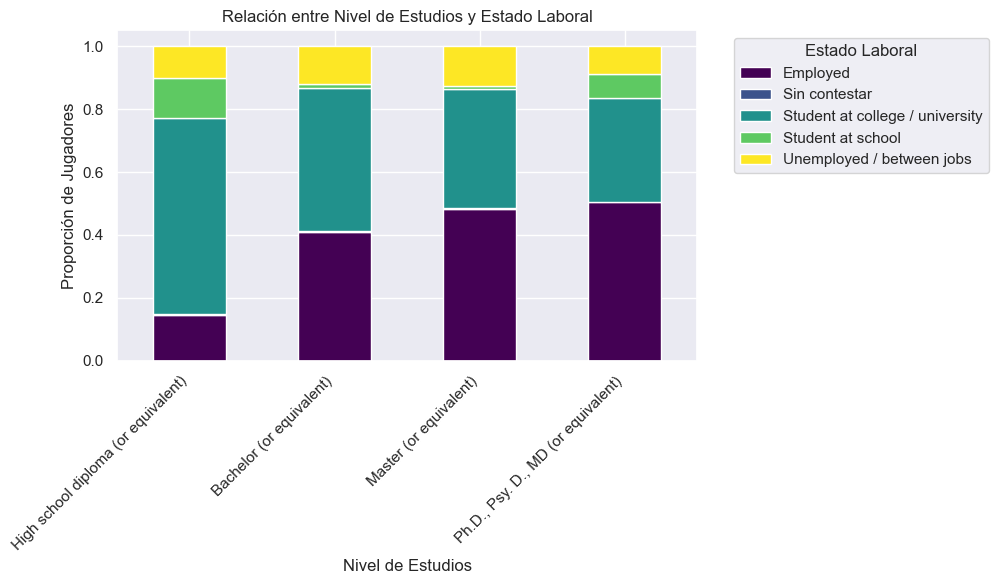

In [ ]:

tabla_estudios_empleo = pd.crosstab(df['Degree'], df['Work'])


tabla_porcentajes = tabla_estudios_empleo.div(tabla_estudios_empleo.sum(1), axis=0)

tabla_porcentajes.plot(kind='bar', 
                       stacked=True, 
                       figsize=(10, 6), 
                       colormap='viridis')

plt.title('Relación entre Nivel de Estudios y Estado Laboral')
plt.xlabel('Nivel de Estudios')
plt.ylabel('Proporción de Jugadores')
plt.legend(title='Estado Laboral', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

Juegos

In [28]:
df["Game"].value_counts()

Game
League of Legends      11284
Other                   1011
Starcraft 2              345
Counter Strike           314
World of Warcraft        152
Hearthstone              101
Diablo 3                  88
Heroes of the Storm       41
Guild Wars 2              37
Skyrim                    28
Destiny                   18
Name: count, dtype: int64

Horas totales

<Axes: ylabel='Frequency'>

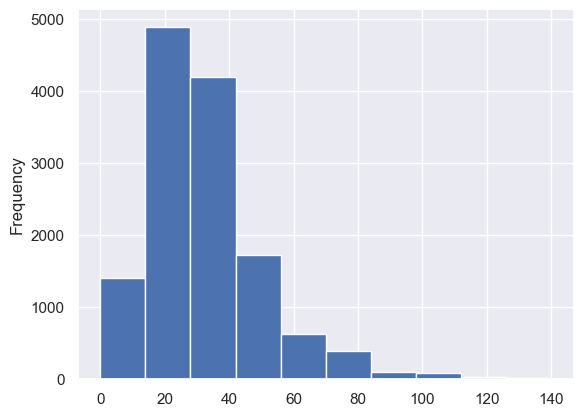

In [65]:
df["Horas_totales"].plot.hist()

Estado mental de la muestra

Ansiedad


In [29]:
df["Nivel_Ansiedad"].value_counts()

Nivel_Ansiedad
Mínima      7430
Leve        3655
Moderada    1603
Severa       731
Name: count, dtype: int64

<Axes: xlabel='GADE'>

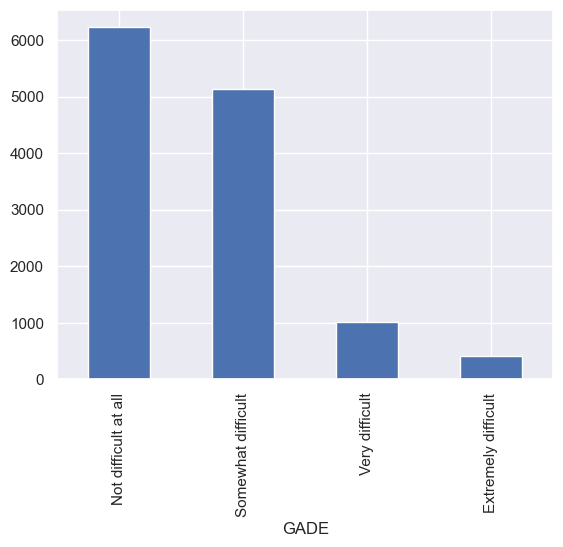

In [30]:
df["GADE"].value_counts().plot.bar()

Satisfación con la vida

<Axes: xlabel='Nivel_Satisfacción'>

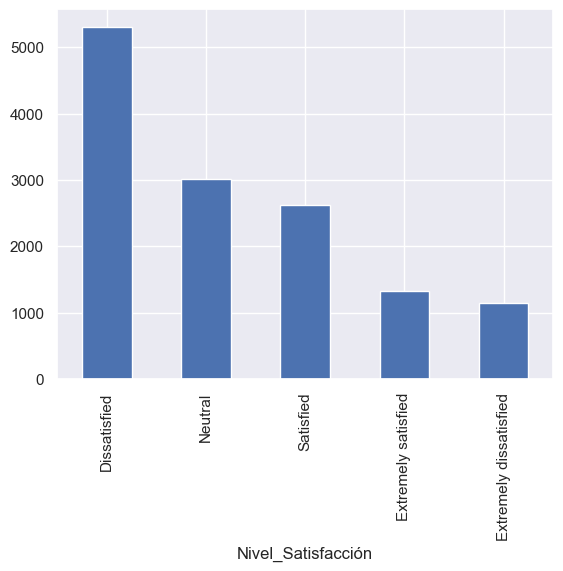

In [31]:
df["Nivel_Satisfacción"].value_counts().plot.bar()

Fobia Social

<Axes: xlabel='Nivel_Fobia_social'>

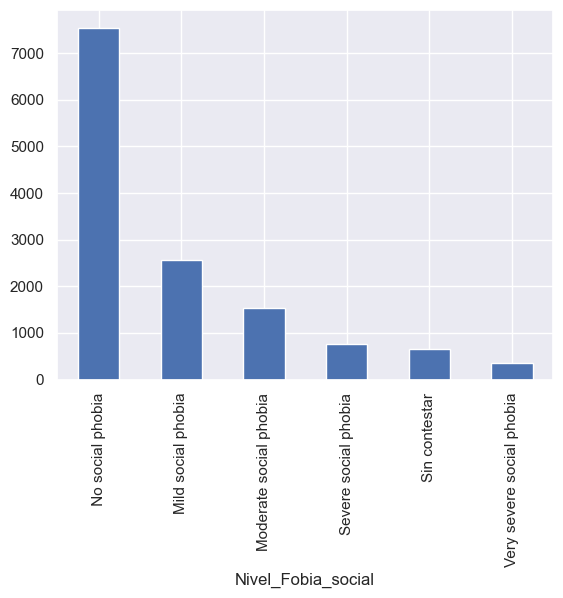

In [32]:
df["Nivel_Fobia_social"].value_counts().plot.bar()

Heatmap

Text(0.5, 1.0, 'Matriz de Correlación: Salud Mental y Hábitos')

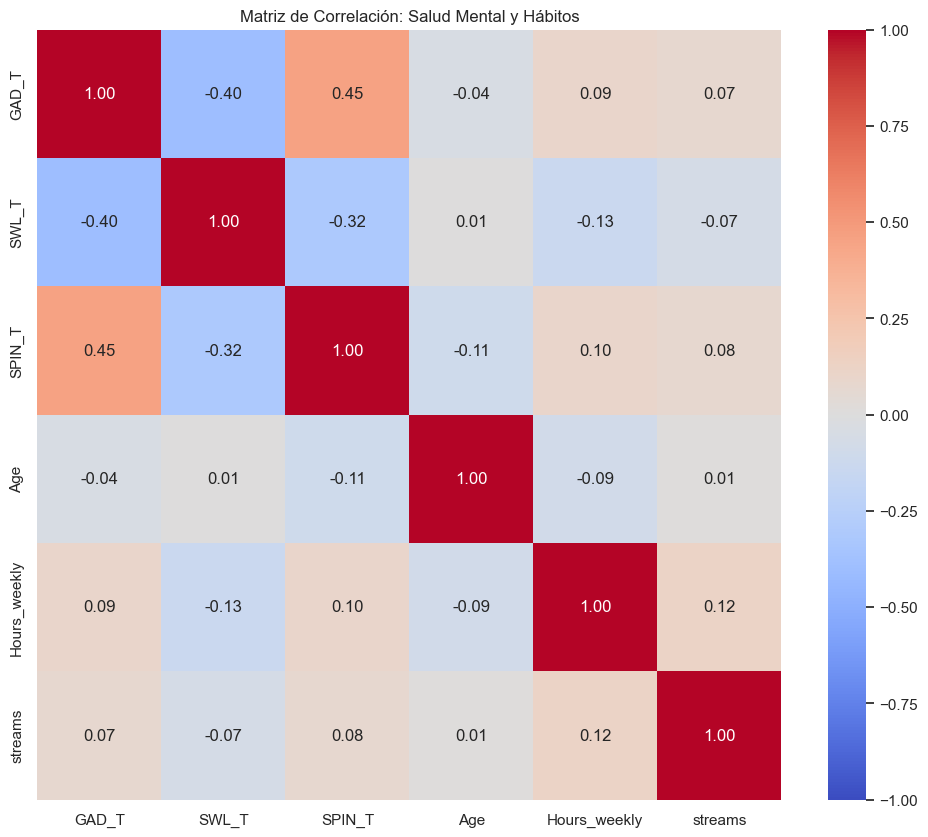

In [34]:
columnas_heatmap=["GAD_T", "SWL_T", "SPIN_T", "Age", 
    "Hours_weekly","streams"]


matriz_corr = df[columnas_heatmap].corr()
plt.figure(figsize=(12, 10))

sns.heatmap(matriz_corr,
            annot=True,
            cmap="coolwarm",
            fmt=".2f",
            vmin=-1,vmax=1,
            center=0)

plt.title("Matriz de Correlación: Salud Mental y Hábitos")

fobia vs playstyle


In [35]:
df["Playstyle"].value_counts()

Playstyle
Multiplayer - online - with real life friends                                   5552
Multiplayer - online - with strangers                                           4123
Multiplayer - online - with online acquaintances or teammates                   2643
Singleplayer                                                                     756
Multiplayer - offline (people in the same room)                                   47
                                                                                ... 
Singleplayer is my favorite, but mostly play with real life friends                1
a mix between rl friends and with strangers depends how im feeling                 1
Multiplayer 2&3                                                                    1
Multiplayer-online acquaintances over several years are real life friends.         1
I usually play online with my real life friends and the internet ones alike.       1
Name: count, Length: 292, dtype: int64

In [ ]:

top_5_playstyles = df['Playstyle'].value_counts().nlargest(5).index

df['Playstyle_Clean'] = df['Playstyle'].where(df['Playstyle'].isin(top_5_playstyles))


print(df['Playstyle_Clean'].value_counts())

Playstyle_Clean
Multiplayer - online - with real life friends                    5552
Multiplayer - online - with strangers                            4123
Multiplayer - online - with online acquaintances or teammates    2643
Singleplayer                                                      756
Multiplayer - offline (people in the same room)                    47
Name: count, dtype: int64


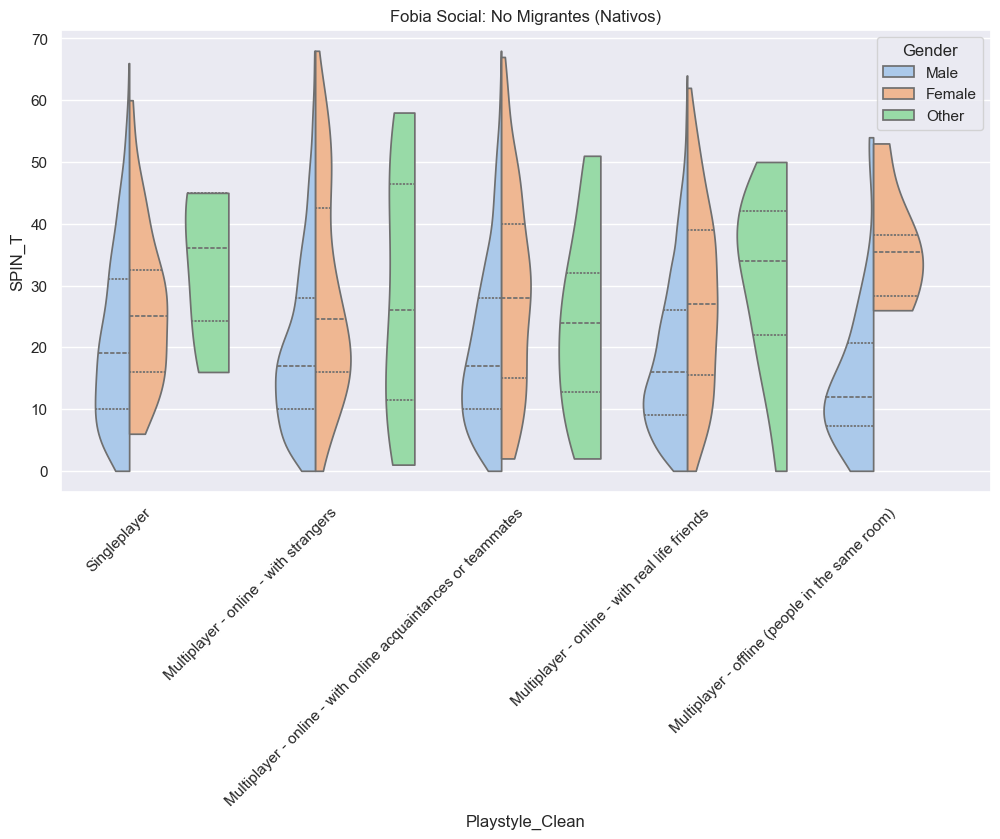

In [37]:
df_social= df[df['Playstyle_Clean'].notna()].copy()
df_locales = df_social[df_social['Is_Migrant'] == 0]
df_migrantes = df_social[df_social['Is_Migrant'] == 1]

plt.figure(figsize=(12, 6))
sns.violinplot(data=df_locales, x="Playstyle_Clean", y="SPIN_T", hue="Gender", 
               split=True, inner="quart", palette="pastel",cut=0)
plt.title('Fobia Social: No Migrantes (Nativos)')
plt.xticks(rotation=45, ha='right')
plt.show()


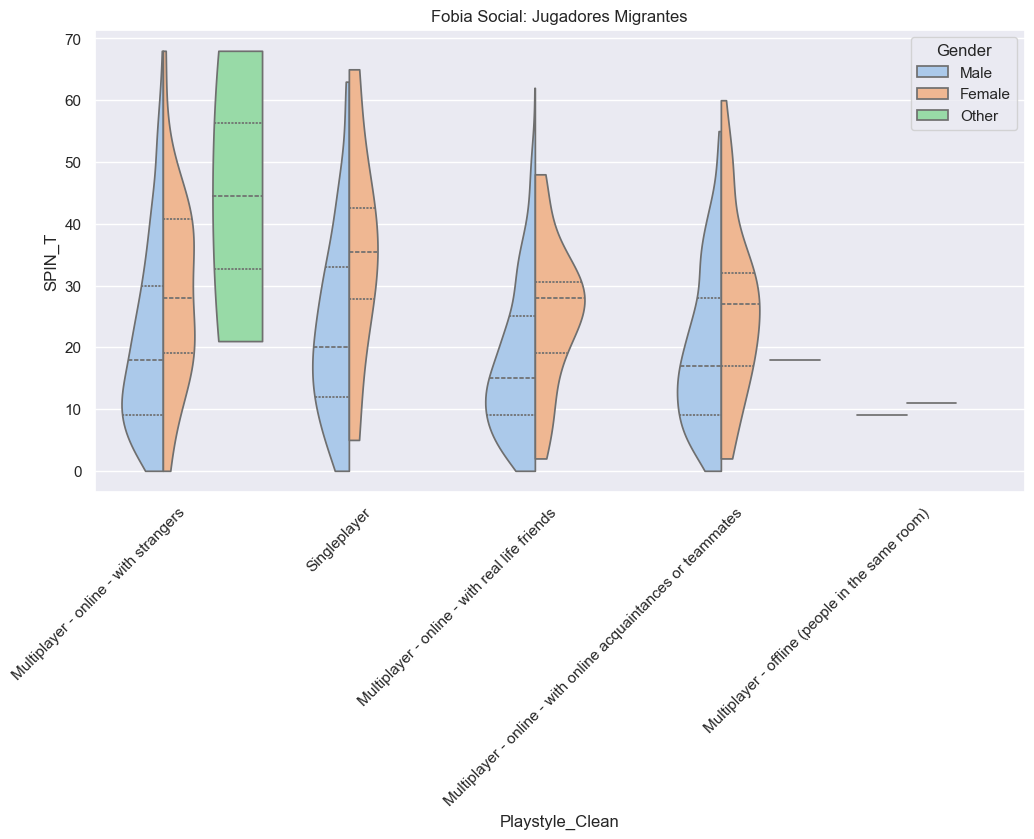

In [66]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_migrantes, x="Playstyle_Clean", y="SPIN_T", hue="Gender", 
               split=True, inner="quart", palette="pastel",cut=0)
plt.title('Fobia Social: Jugadores Migrantes')
plt.xticks(rotation=45, ha='right')
plt.show()

nivel de fobia segun el motivo de juego

Text(0.5, 0, 'Motivo Principal')

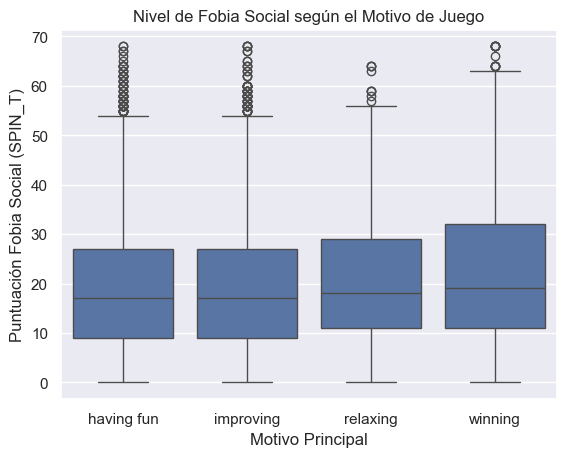

In [39]:
orden= df.groupby('whyplay_Clean')['SPIN_T'].median().sort_values().index


sns.boxplot(data=df,x="whyplay_Clean",y="SPIN_T",order=orden)
plt.title("Nivel de Fobia Social según el Motivo de Juego")
plt.ylabel('Puntuación Fobia Social (SPIN_T)')
plt.xlabel('Motivo Principal')




Ansiedad


<Axes: xlabel='Nivel_Ansiedad', ylabel='Horas_totales'>

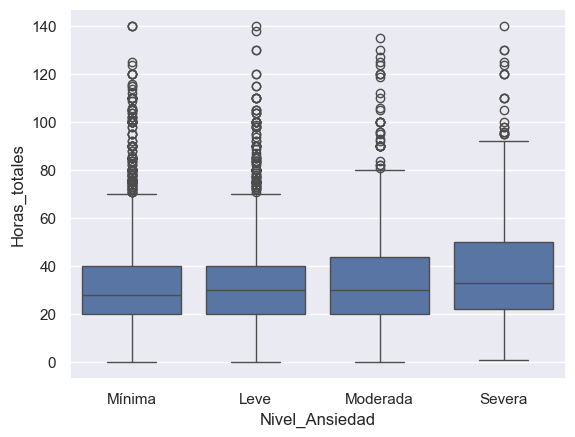

In [42]:
sns.boxplot(data=df,x="Nivel_Ansiedad",y="Horas_totales")

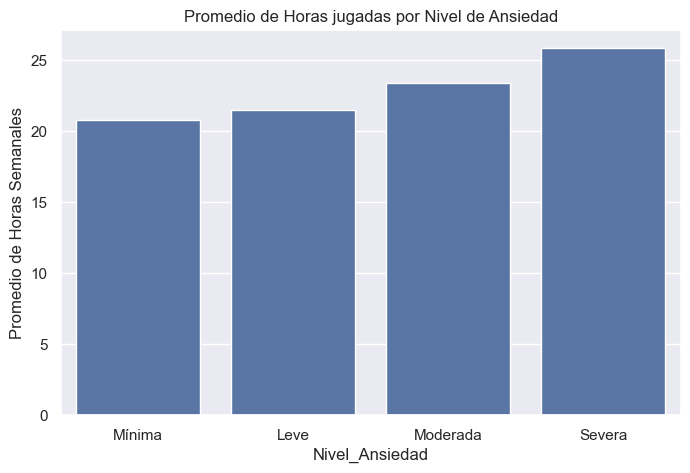

In [43]:
plt.figure(figsize=(8, 5))

# 'errorbar=None' quita las rayitas negras de arriba para que quede limpio
sns.barplot(data=df, x="Nivel_Ansiedad", y="Hours_weekly", 
            order=['Mínima', 'Leve', 'Moderada', 'Severa'],
            estimator='mean', errorbar=None)

plt.title("Promedio de Horas jugadas por Nivel de Ansiedad")
plt.ylabel("Promedio de Horas Semanales")
plt.show()

In [ ]:

top_4_reasons = df['whyplay'].value_counts().nlargest(4).index



df['whyplay_Clean'] = df['whyplay'].where(df['whyplay'].isin(top_4_reasons))

In [45]:
df['whyplay_Clean'].value_counts()

whyplay_Clean
having fun    5279
improving     4910
winning       2080
relaxing       652
Name: count, dtype: int64

In [46]:
# 1. Definimos el orden lógico de los rangos de LoL
orden_rangos = ["Unranked", "Bronze", "Silver", "Gold", "Platinum", "Diamond", "Master", "Challenger"]


<Axes: xlabel='LOL_Rank', ylabel='count'>

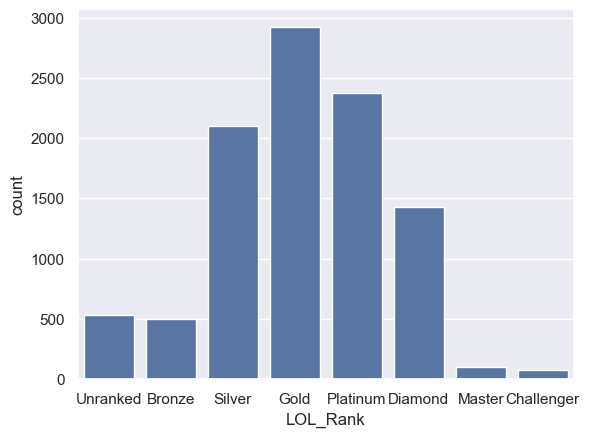

In [47]:
sns.countplot(data=df,x="LOL_Rank",order=orden_rangos)

C:\Users\ismae\AppData\Local\Temp\ipykernel_14072\4247736994.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




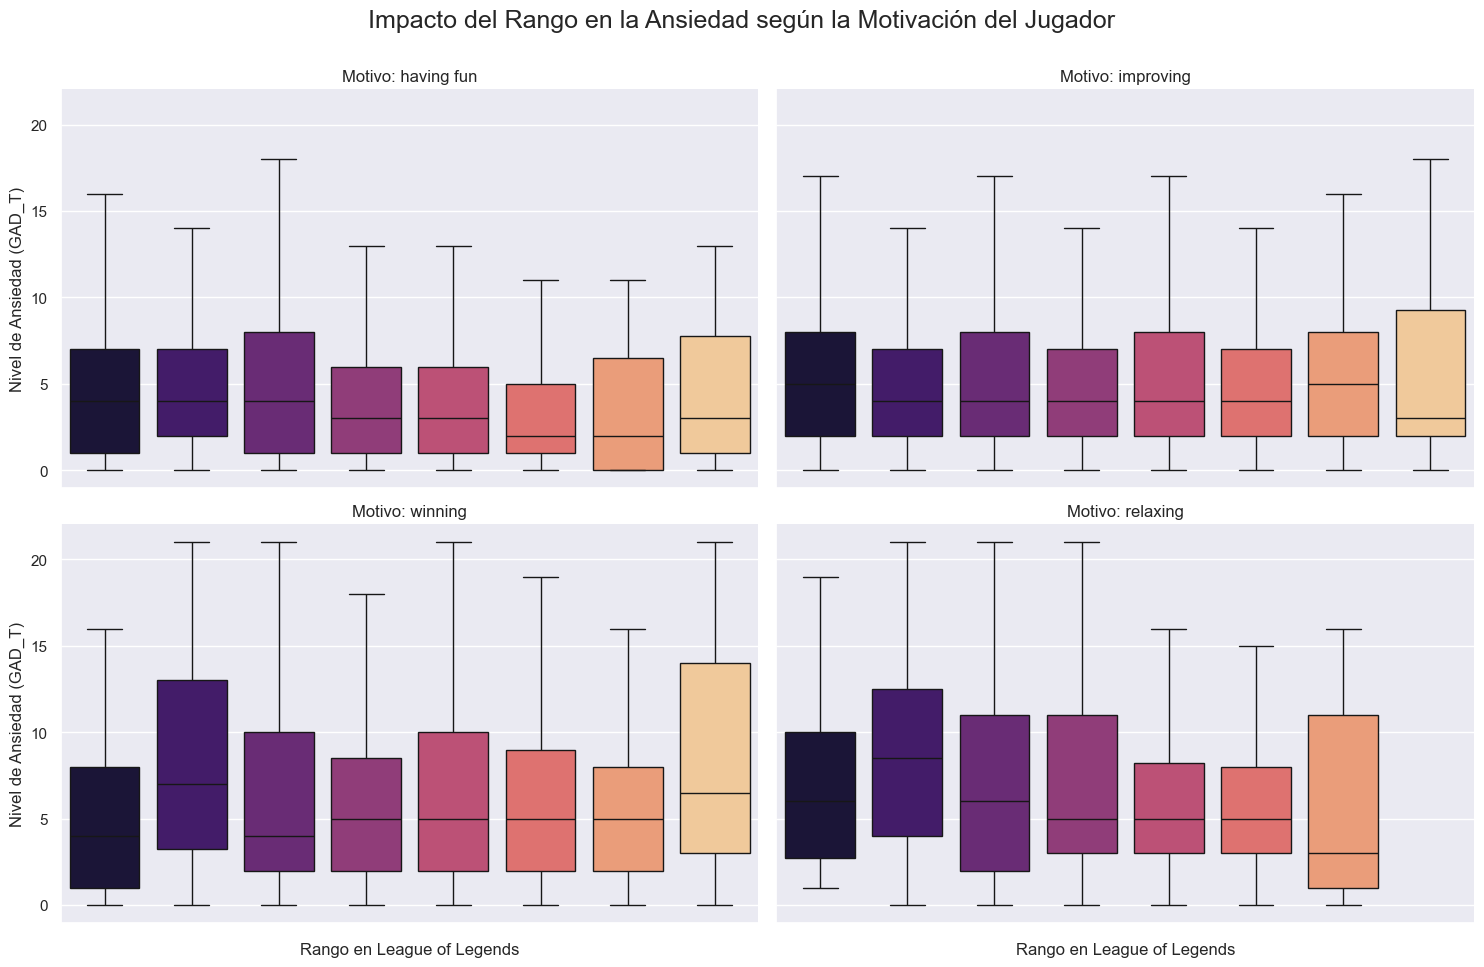

In [ ]:

df_plot = df[df['LOL_Rank'].isin(orden_rangos) & df['whyplay_Clean'].notna()].copy()


g = sns.catplot(
    data=df_plot, 
    x="LOL_Rank", 
    y="GAD_T", 
    col="whyplay_Clean", 
    col_wrap=2,           
    kind="box", 
    order=orden_rangos,
    palette="magma",      #cambiar  a colores de los rangos
    height=5, 
    aspect=1.5,
    showfliers=False      
)


g.set_xticklabels(rotation=45)
g.set_titles("Motivo: {col_name}")
g.set_axis_labels("Rango en League of Legends", "Nivel de Ansiedad (GAD_T)")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Impacto del Rango en la Ansiedad según la Motivación del Jugador', fontsize=18)

plt.show()

In [49]:
rank_mapping = {
    "Unranked": 0,
    "Bronze": 1,
    "Silver": 2,
    "Gold": 3,
    "Platinum": 4,
    "Diamond": 5,
    "Master": 6,
    "Challenger": 7
}

# 2. Creamos la columna Rank_Num usando el mapeo
df['Rank_Num'] = df['LOL_Rank'].map(rank_mapping)

In [ ]:


df_filtrado = df[df['LOL_Rank'].isin(orden_rangos) & df['whyplay_Clean'].notna()]


heatmap_data = df_filtrado.pivot_table(
    index='whyplay_Clean', 
    columns='LOL_Rank', 
    values='GAD_T', 
    aggfunc='mean'
)


heatmap_data = heatmap_data[orden_rangos]

C:\Users\ismae\AppData\Local\Temp\ipykernel_14072\1512872290.py:7: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



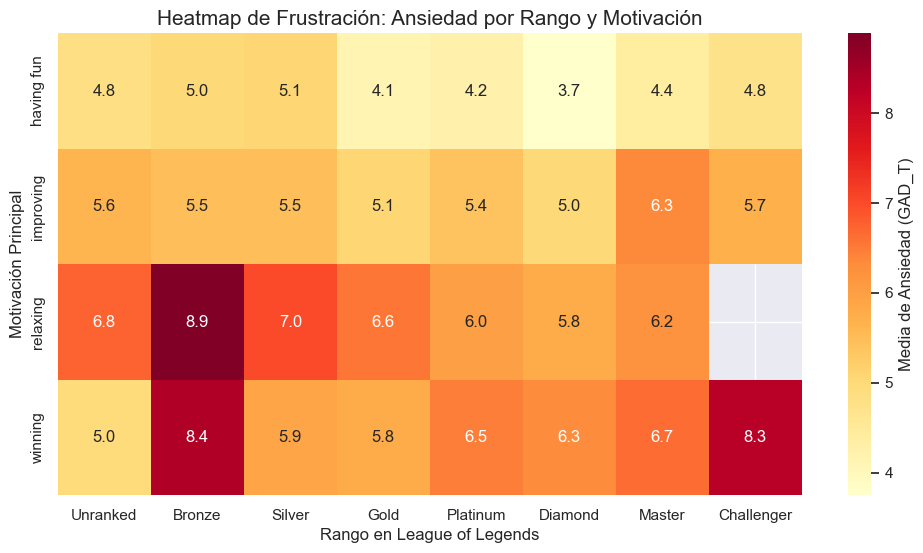

In [ ]:


plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data, 
    annot=True,          
    fmt=".1f",           
    cmap="YlOrRd",       
    cbar_kws={'label': 'Media de Ansiedad (GAD_T)'}
)

plt.title('Heatmap de Frustración: Ansiedad por Rango y Motivación', fontsize=15)
plt.xlabel('Rango en League of Legends')
plt.ylabel('Motivación Principal')
plt.show()

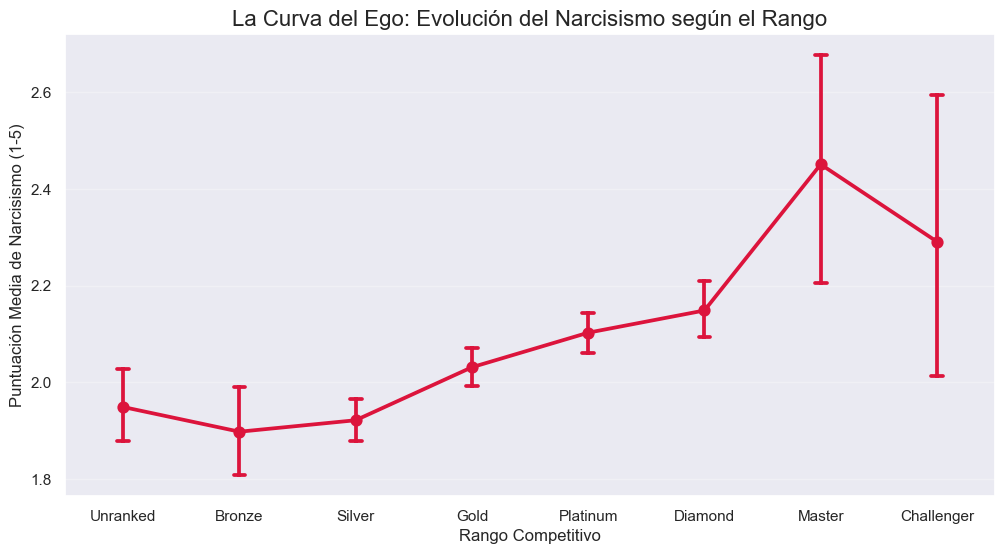

In [ ]:
plt.figure(figsize=(12, 6))


sns.pointplot(
    data=df, 
    x="LOL_Rank", 
    y="Narcissism", 
    order=orden_rangos,
    color="crimson",       
    capsize=0.1,           
    markers="o",
    linestyles="-"
)

plt.title('La Curva del Ego: Evolución del Narcisismo según el Rango', fontsize=16)
plt.ylabel('Puntuación Media de Narcisismo (1-5)')
plt.xlabel('Rango Competitivo')
plt.grid(axis='y', alpha=0.3)

plt.show()

C:\Users\ismae\AppData\Local\Temp\ipykernel_14072\4125271363.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




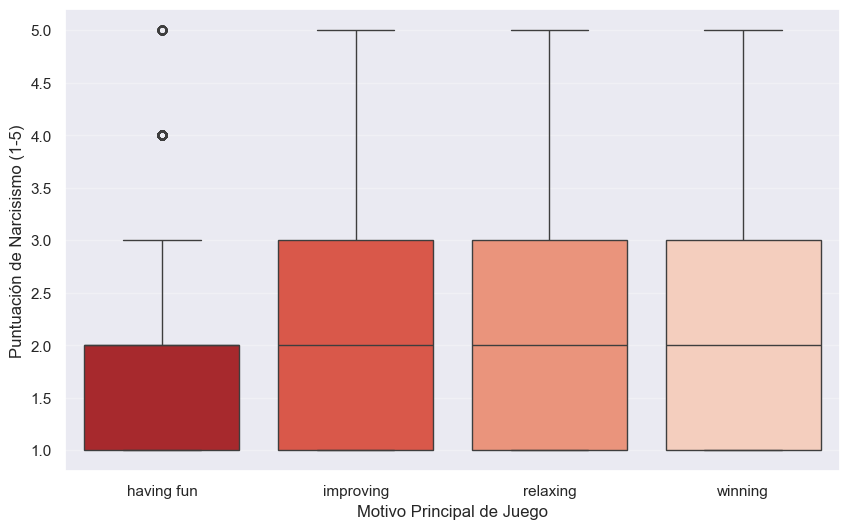

In [ ]:


plt.figure(figsize=(10, 6))

orden_ego = df.groupby('whyplay_Clean')['Narcissism'].median().sort_values(ascending=False).index


sns.boxplot(
    data=df, 
    x="whyplay_Clean", 
    y="Narcissism", 
    order=orden_ego,
    palette="Reds_r"
)


plt.xlabel('Motivo Principal de Juego')
plt.ylabel('Puntuación de Narcisismo (1-5)')
plt.grid(axis='y', alpha=0.3)

plt.show()

In [ ]:

stats = df[df['whyplay_Clean'] == 'having fun']['Narcissism'].describe(percentiles=[.25, .5, .75])
print("Estadísticas de 'Having Fun':")
print(stats[['25%', '50%', '75%']])

Estadísticas de 'Having Fun':
25%    1.0
50%    2.0
75%    2.0
Name: Narcissism, dtype: float64


satisfaccion

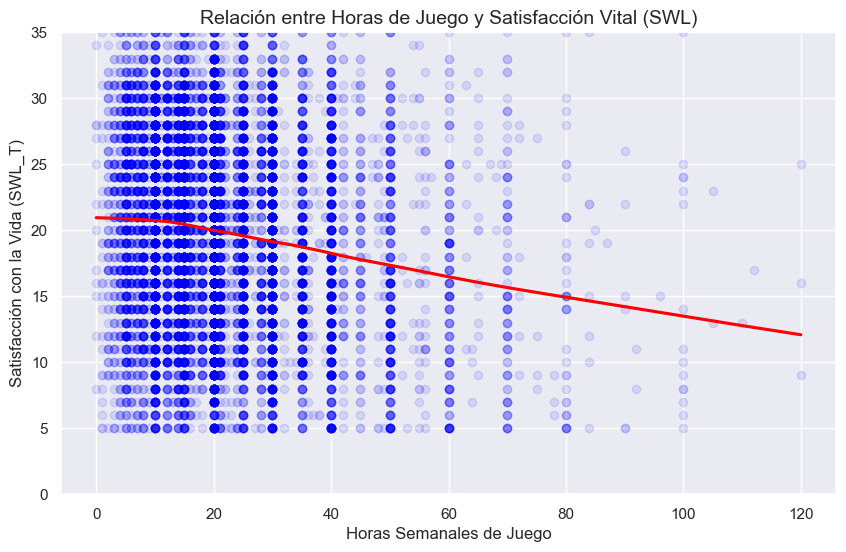

In [ ]:


plt.figure(figsize=(10, 6))


sns.regplot(
    data=df, 
    x="Hours_weekly", 
    y="SWL_T", 
    lowess=True,
    scatter_kws={'alpha':0.1, 'color':'blue'}, 
    line_kws={'color':'red'}
)

plt.title('Relación entre Horas de Juego y Satisfacción Vital (SWL)', fontsize=14)
plt.xlabel('Horas Semanales de Juego')
plt.ylabel('Satisfacción con la Vida (SWL_T)')
plt.ylim(0, 35)
plt.show()

C:\Users\ismae\AppData\Local\Temp\ipykernel_14072\3587163957.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




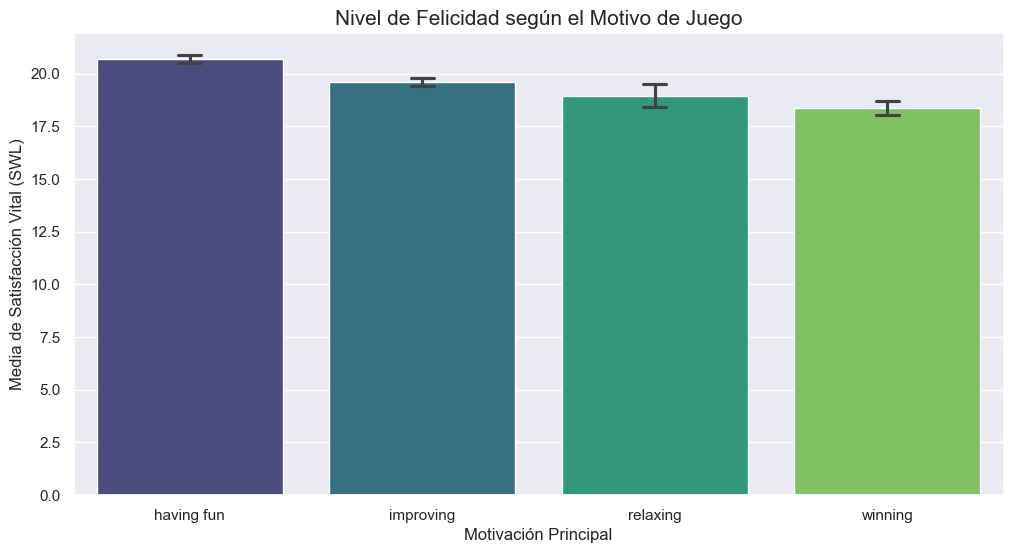

In [ ]:

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df[df['whyplay_Clean'].notna()], 
    x="whyplay_Clean", 
    y="SWL_T", 
    palette="viridis",
    capsize=.1
)

plt.title('Nivel de Felicidad según el Motivo de Juego', fontsize=15)
plt.ylabel('Media de Satisfacción Vital (SWL)')
plt.xlabel('Motivación Principal')
plt.show()

C:\Users\ismae\AppData\Local\Temp\ipykernel_14072\3071287332.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




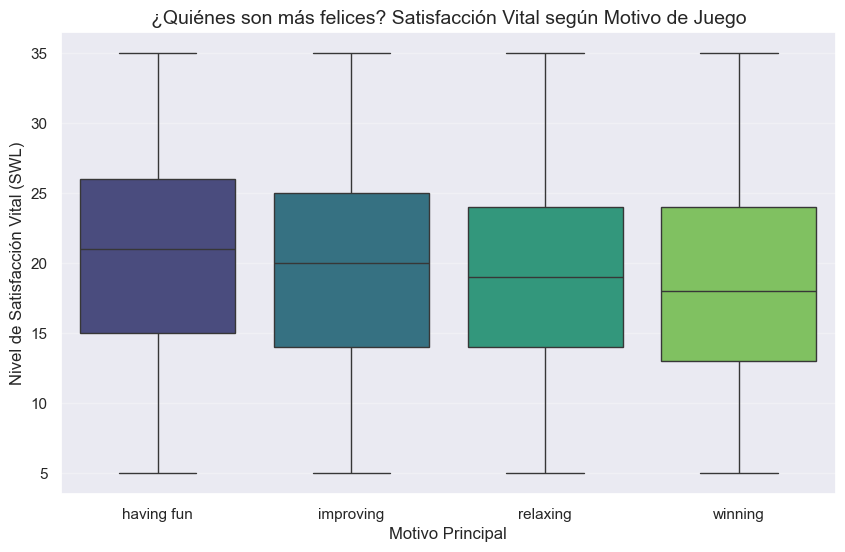

In [ ]:

orden_felicidad = df.groupby('whyplay_Clean')['SWL_T'].median().sort_values(ascending=False).index

plt.figure(figsize=(10, 6))

sns.boxplot(
    data=df,
    x="whyplay_Clean",
    y="SWL_T",
    order=orden_felicidad,
    palette="viridis"
)

plt.title('¿Quiénes son más felices? Satisfacción Vital según Motivo de Juego', fontsize=14)
plt.xlabel('Motivo Principal')
plt.ylabel('Nivel de Satisfacción Vital (SWL)')
plt.grid(axis='y', alpha=0.3)

plt.show()

C:\Users\ismae\AppData\Local\Temp\ipykernel_14072\3430914861.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




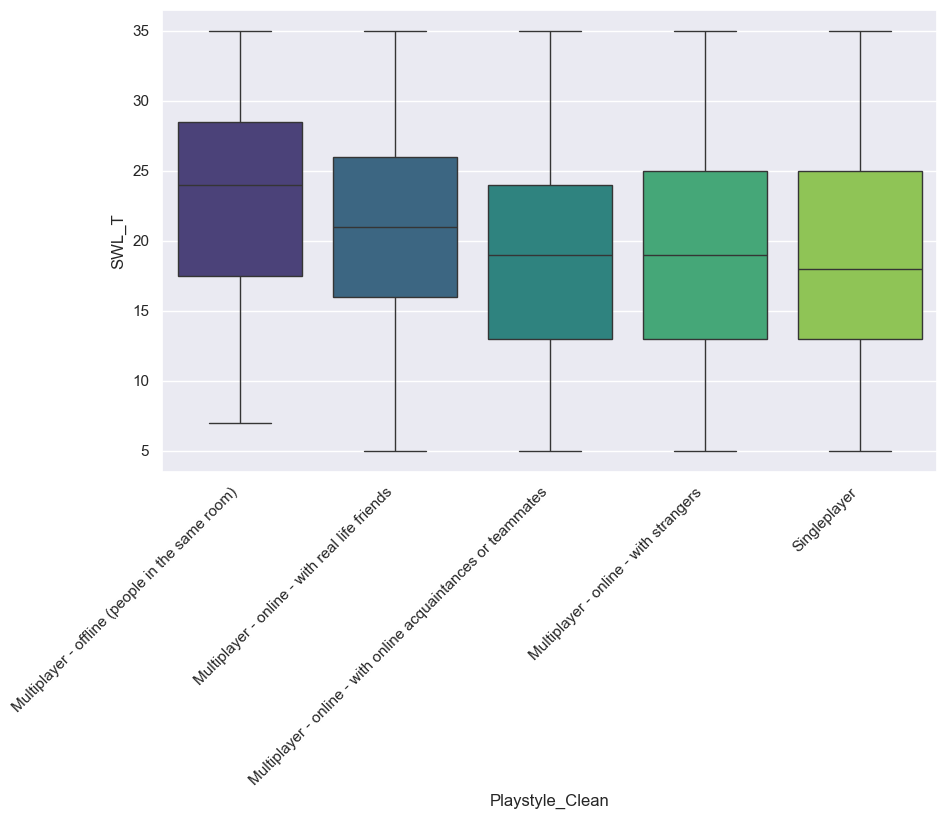

In [70]:
orden_felicidad2 = df.groupby('Playstyle_Clean')['SWL_T'].median().sort_values(ascending=False).index

plt.figure(figsize=(10, 6))

sns.boxplot(
    data=df,
    x="Playstyle_Clean",
    y="SWL_T",
    order=orden_felicidad2,
    palette="viridis"
)

plt.xticks(rotation=45, ha='right')
plt.show()

C:\Users\ismae\AppData\Local\Temp\ipykernel_14072\4139233004.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\ismae\AppData\Local\Temp\ipykernel_14072\4139233004.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\ismae\AppData\Local\Temp\ipykernel_14072\4139233004.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




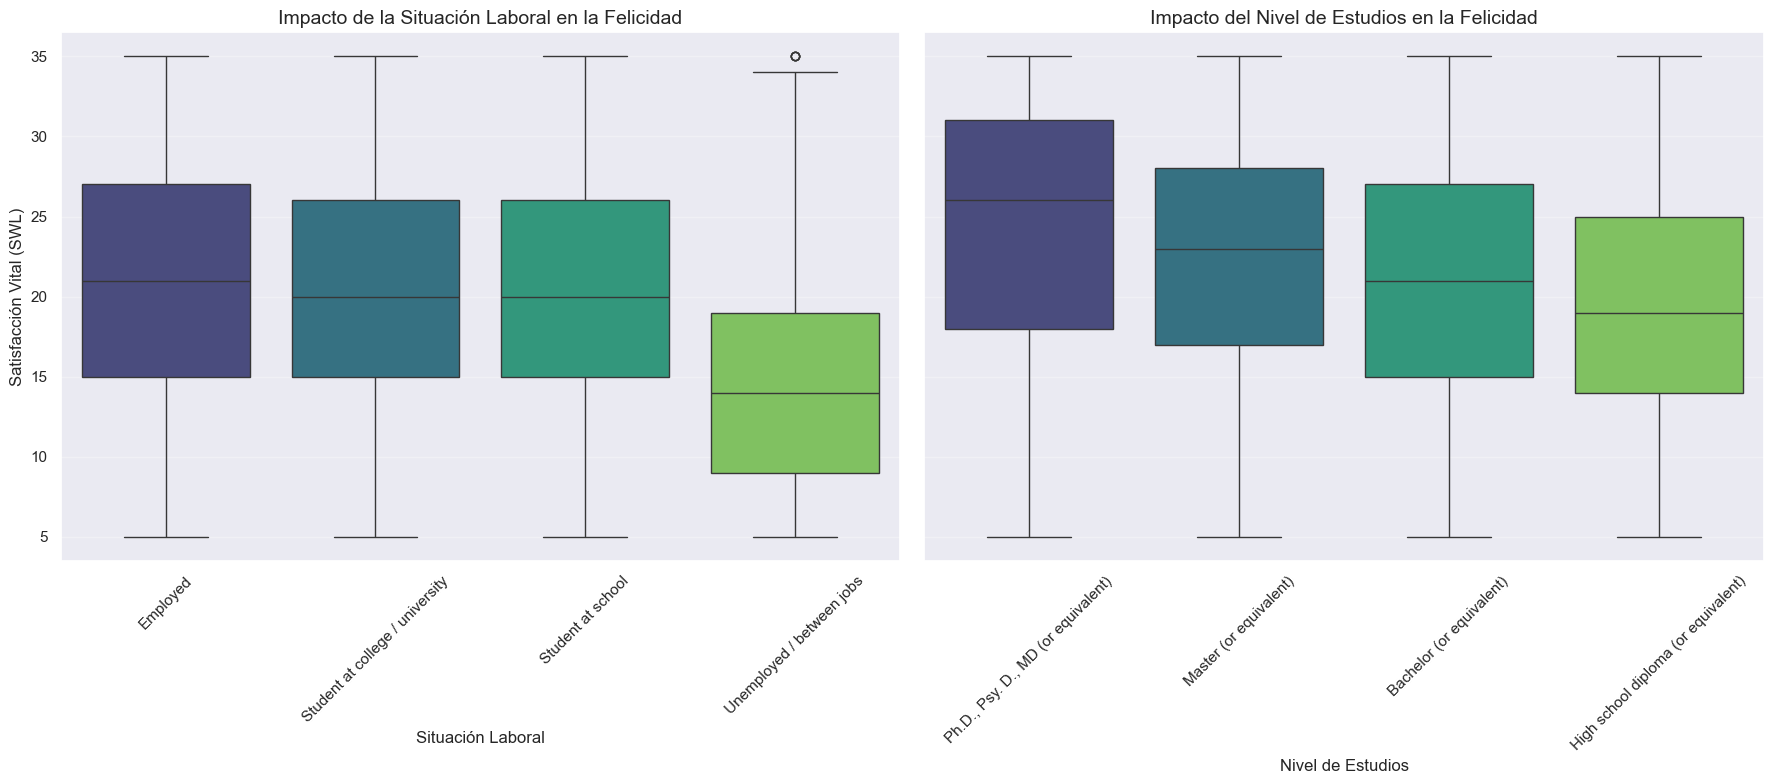

In [68]:


fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)



df_limpio_work= df[df['Work'] != 'Sin contestar'].copy()


order_work = df_limpio_work.groupby('Work')['SWL_T'].median().sort_values(ascending=False).index

sns.boxplot(
    data=df,
    x='Work',
    y='SWL_T',
    order=order_work,
    palette="viridis",
    ax=axes[0]
)
axes[0].set_title('Impacto de la Situación Laboral en la Felicidad', fontsize=14)
axes[0].set_xlabel('Situación Laboral')
axes[0].set_ylabel('Satisfacción Vital (SWL)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)


order_degree = df.groupby('Degree')['SWL_T'].median().sort_values(ascending=False).index

sns.boxplot(
    data=df,
    x='Degree',
    y='SWL_T',
    order=order_degree,
    palette="viridis",
    ax=axes[1]
)
axes[1].set_title('Impacto del Nivel de Estudios en la Felicidad', fontsize=14)
axes[1].set_xlabel('Nivel de Estudios')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

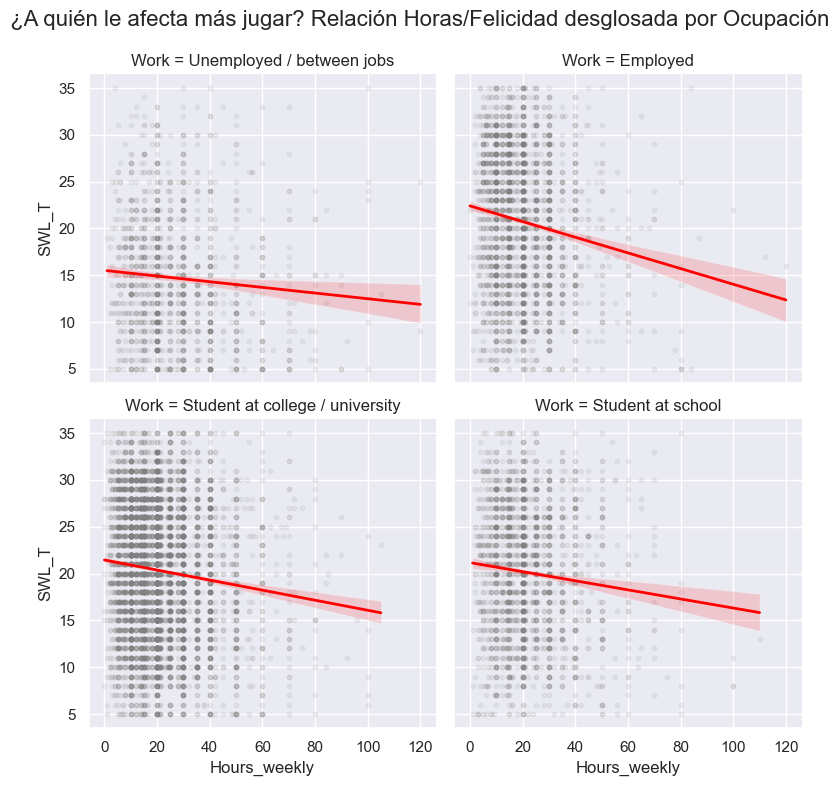

In [59]:



sns.lmplot(
    data=df_limpio_work,
    x="Hours_weekly",
    y="SWL_T",
    col="Work",       
    col_wrap=2,        
    height=4,         
    aspect=1,        
    scatter_kws={'alpha': 0.1, 's': 10, 'color': 'gray'}, 
    line_kws={'color': 'red', 'linewidth': 2} 
)

plt.subplots_adjust(top=0.9)
plt.suptitle('¿A quién le afecta más jugar? Relación Horas/Felicidad desglosada por Ocupación', fontsize=16)

plt.show()

clustering

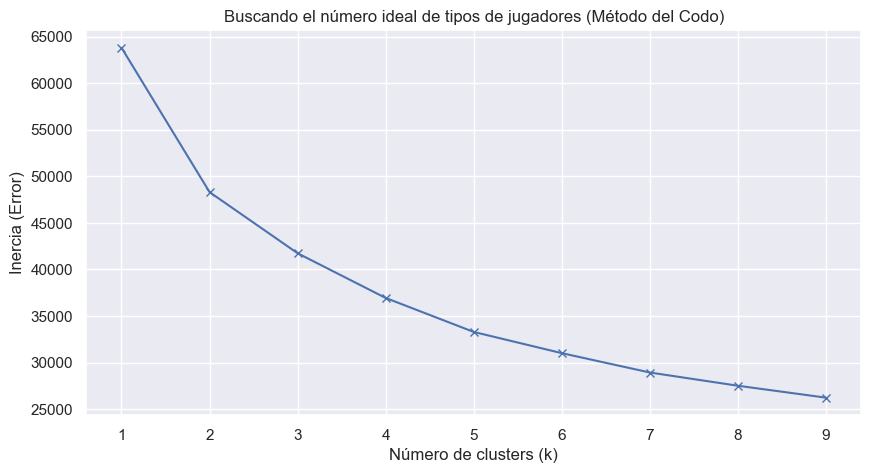

In [60]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Seleccionamos las variables numéricas clave
features_clustering = ['GAD_T', 'SPIN_T', 'SWL_T', 'Narcissism', 'Hours_weekly']

# Creamos un dataframe solo con eso para el algoritmo
df_cluster = df[features_clustering].dropna()

# 2. Escalamos (Fundamental: para que las horas no pesen más que el narcisismo)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df_cluster)

# 3. Método del Codo para decidir cuántos grupos hay
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeanModel.fit(x_scaled)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (Error)')
plt.title('Buscando el número ideal de tipos de jugadores (Método del Codo)')
plt.show()

In [87]:
# 1. Ejecutamos K-Means con k=3
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_cluster['Cluster'] = kmeans.fit_predict(x_scaled)

# Mapeamos los nombres para que en los gráficos no salga "0, 1, 2"
# Luego los cambiaremos por nombres más "chulos" según lo que veamos
df_cluster['Perfil_Jugador'] = df_cluster['Cluster'].map({
    0: 'Grupo A',
    1: 'Grupo B',
    2: 'Grupo C',
    3: 'Grupo D',
})

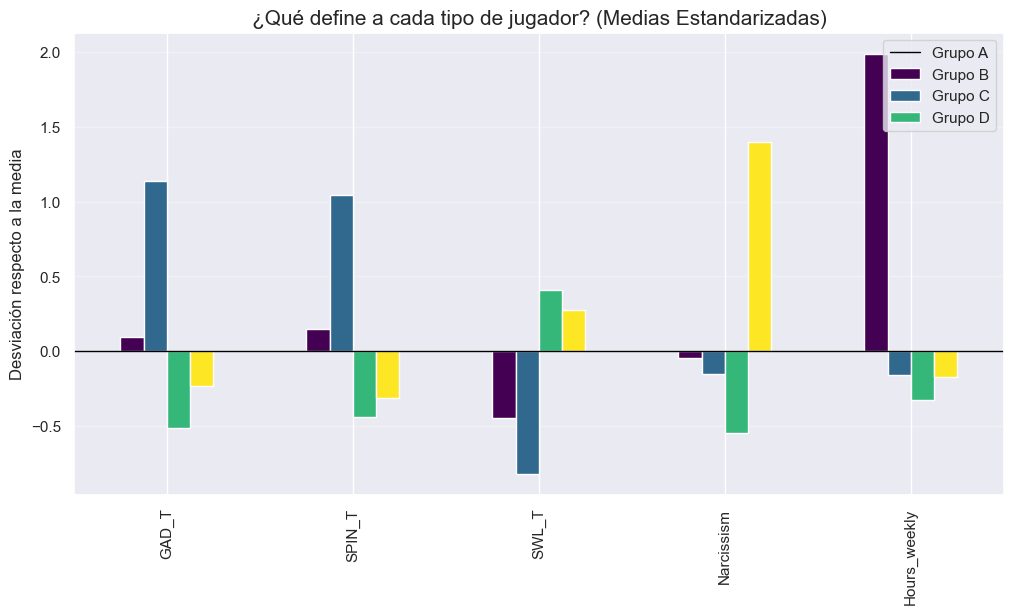

In [89]:
# Calculamos la media de cada variable por cluster
resumen_clusters = pd.DataFrame(x_scaled, columns=features_clustering)
resumen_clusters['Cluster'] = df_cluster['Cluster'].values
resumen_visual = resumen_clusters.groupby('Cluster').mean().T

# Graficamos
resumen_visual.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('¿Qué define a cada tipo de jugador? (Medias Estandarizadas)', fontsize=15)
plt.axhline(0, color='black', linewidth=1) # La línea del 0 es la media total de la muestra
plt.ylabel('Desviación respecto a la media')
plt.legend(['Grupo A', 'Grupo B', 'Grupo C','Grupo D'], loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [82]:
# Primero unimos los clusters con las variables de texto que tenías en el df original
df_final = df_cluster.join(df[['Work', 'Degree', 'whyplay_Clean', 'LOL_Rank','Playstyle_Clean','whyplay_Clean']])

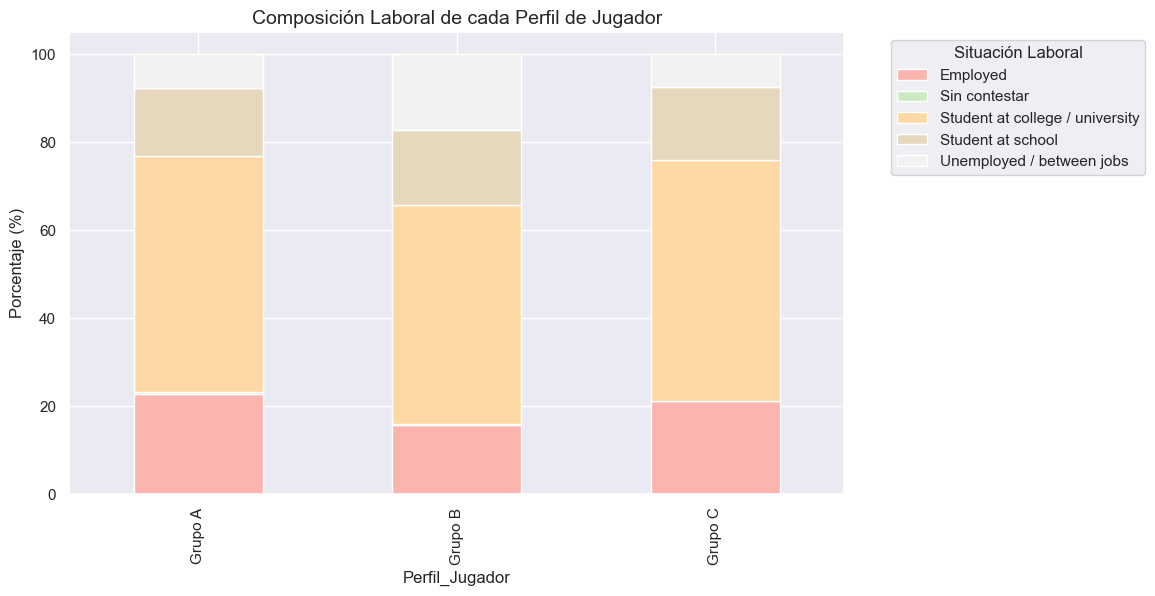

In [90]:

# Creamos una tabla de proporciones para el Trabajo
trabajo_por_cluster = pd.crosstab(df_final['Perfil_Jugador'], df_final['Work'], normalize='index') * 100

# Graficamos el perfil social de cada cluster
trabajo_por_cluster.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Pastel1')
plt.title('Composición Laboral de cada Perfil de Jugador', fontsize=14)
plt.ylabel('Porcentaje (%)')
plt.legend(title='Situación Laboral', bbox_to_anchor=(1.05, 1))
plt.show()

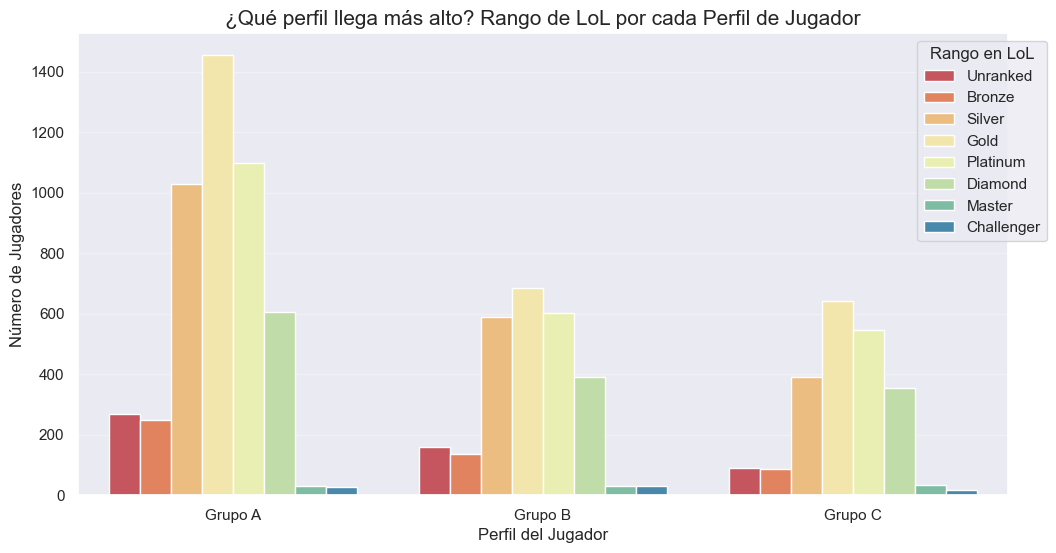

In [64]:
# Gráfico de Rangos por Perfil de Jugador
plt.figure(figsize=(12, 6))

# Ordenamos los rangos de menor a mayor para que el gráfico tenga sentido
orden_rangos = ["Unranked", "Bronze", "Silver", "Gold", "Platinum", "Diamond", "Master", "Challenger"]

# Creamos el gráfico de barras comparativo
sns.countplot(
    data=df_final, 
    x='Perfil_Jugador', 
    hue='LOL_Rank', 
    hue_order=orden_rangos,
    palette='Spectral'
)

plt.title('¿Qué perfil llega más alto? Rango de LoL por cada Perfil de Jugador', fontsize=15)
plt.ylabel('Número de Jugadores')
plt.xlabel('Perfil del Jugador')
plt.legend(title='Rango en LoL', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y', alpha=0.3)
plt.show()

In [81]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12762 entries, 0 to 13463
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   GAD_T            12762 non-null  int64   
 1   SPIN_T           12762 non-null  float64 
 2   SWL_T            12762 non-null  int64   
 3   Narcissism       12762 non-null  float64 
 4   Hours_weekly     12762 non-null  float64 
 5   Cluster          12762 non-null  int32   
 6   Perfil_Jugador   12762 non-null  object  
 7   Work             12762 non-null  object  
 8   Degree           11285 non-null  category
 9   whyplay_Clean    12301 non-null  object  
 10  LOL_Rank         9551 non-null   category
 11  Playstyle_Clean  12477 non-null  object  
 12  whyplay_Clean    12301 non-null  object  
dtypes: category(2), float64(3), int32(1), int64(2), object(5)
memory usage: 1.1+ MB


<Axes: xlabel='Perfil_Jugador', ylabel='count'>

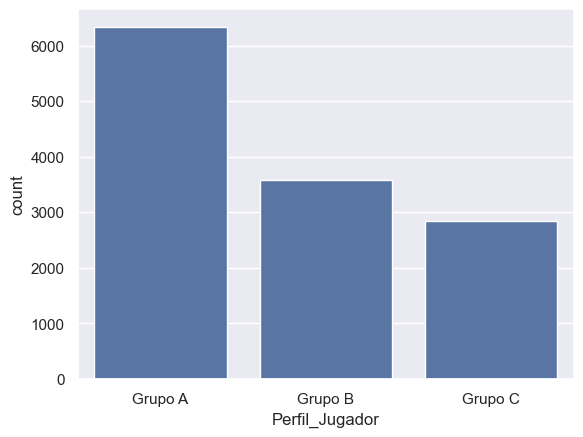

In [85]:

sns.countplot(
    data=df_final, 
    x='Perfil_Jugador', 
    )

In [86]:
sns.countplot(
    data=df_final,
    x='Perfil_Jugador',
    hue='whyplay_Clean'
)

ValueError: 2